# Requires to have in 'data/clean/' the data : 'merged_dataframe.pkl' & 'ligands_related_to_cancer_proteins.pkl'

imports

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re


### Import clean datasets

In [77]:

df = pd.read_pickle('data/clean/merged_dataframe.pkl')
cancer_df = pd.read_pickle('data/clean/ligands_related_to_cancer_proteins.pkl')


### Keep only the ones matched with Drugbank to have the toxicity reports

In [78]:
df_matched = df[df['Matched_On'].isna() == False]
cancer_df_matched = cancer_df[cancer_df['Matched_On'].isna() == False]


### Find the drugs linked to our 11 most studied cancer related proteins

In [79]:
highly_studied_proteins = ['Cytochrome P450 3A4', 'Epidermal growth factor receptor', 'Proto-oncogene tyrosine-protein kinase Src', 'Vascular endothelial growth factor receptor 2', 'Adenosine receptor A2a', 'Cytochrome P450 2C9', 'Cytochrome P450 1A2', 'Cytochrome P450 2C19', 'Cytochrome P450 2D6', 'Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2']
# joins all targeted proteins
pattern_highly_studied =  '|'.join(rf"\b{re.escape(term)}\b" for term in highly_studied_proteins)

# extract rows based on the columns that contain highly_studied_proteins 
filtered_df_highly_studied = df_matched[df_matched['target_name'].str.contains(pattern_highly_studied, case=False, na=False)]
filtered_df_highly_studied.reset_index(inplace=True)

cancer_most_studied_drugs = filtered_df_highly_studied.drugbank_drug_name.unique()

# rows from df_matched that have a drugbank_drug_name that is in cancer_most_studied_drugs
cancer_most_studied_df = df_matched[df_matched['drugbank_drug_name'].isin(cancer_most_studied_drugs)]


### Printing interesting numbers. ! NOT SURE WE WANT TO INCLUDE IT ... !

In [80]:
print("For cancer related proteins :")
print(f"We have found {len(cancer_df_matched.inchi_key.unique())} unique proteins, but only {len(cancer_df_matched.target_name.unique())} when looking at the more generic target names.")
# print(f"Proportion of unique drugs per unique protein {len(cancer_df_matched.drugbank_drug_name.unique())/len(cancer_df_matched.target_name.unique())}")
print(f"Number of unique drugs : {len(cancer_df_matched.drugbank_drug_name.unique())}.")
print(f"Number of unique ligands : {len(cancer_df_matched.ligand_name.unique())}")
print(f"Total number of entries : {len(cancer_df_matched)}")


For cancer related proteins :
We have found 1099 unique proteins, but only 83 when looking at the more generic target names.
Number of unique drugs : 1069.
Number of unique ligands : 1150
Total number of entries : 9493


In [81]:
print("For our expanded search around the 11 highly researched proteins :")
print(f"We have found {len(cancer_most_studied_df.inchi_key.unique())} unique proteins, but only {len(cancer_most_studied_df.target_name.unique())} when looking at the more generic target names.")
# print(f"Proportion of unique drugs per unique protein {len(cancer_df_matched.drugbank_drug_name.unique())/len(cancer_df_matched.target_name.unique())}")
print(f"Number of unique drugs : {len(cancer_most_studied_df.drugbank_drug_name.unique())}.")
print(f"Number of unique ligands : {len(cancer_most_studied_df.ligand_name.unique())}")
print(f"Total number of entries : {len(cancer_most_studied_df)}")

For our expanded search around the 11 highly researched proteins :
We have found 975 unique proteins, but only 2255 when looking at the more generic target names.
Number of unique drugs : 896.
Number of unique ligands : 1113
Total number of entries : 80157


In [82]:
print("For all BDB:")
print(f"We have found {len(df.inchi_key.unique())} unique proteins, but only {len(df.target_name.unique())} when looking at the more generic target names.")
# print(f"Proportion of unique drugs per unique protein {len(cancer_df_matched.drugbank_drug_name.unique())/len(cancer_df_matched.target_name.unique())}")
print(f"Number of unique drugs : {len(df.drugbank_drug_name.unique())}.")
print(f"Number of unique ligands : {len(df.ligand_name.unique())}")
print(f"Total number of entries : {len(df)}")

For all BDB:
We have found 1212306 unique proteins, but only 6741 when looking at the more generic target names.
Number of unique drugs : 5717.
Number of unique ligands : 1287271
Total number of entries : 2927609


In [83]:
print("For all merged BDB/Drugbank:")
print(f"We have found {len(df_matched.inchi_key.unique())} unique proteins, but only {len(df_matched.target_name.unique())} when looking at the more generic target names.")
# print(f"Proportion of unique drugs per unique protein {len(cancer_df_matched.drugbank_drug_name.unique())/len(cancer_df_matched.target_name.unique())}")
print(f"Number of unique drugs : {len(df_matched.drugbank_drug_name.unique())}.")
print(f"Number of unique ligands : {len(df_matched.ligand_name.unique())}")
print(f"Total number of entries : {len(df_matched)}")

For all merged BDB/Drugbank:
We have found 5998 unique proteins, but only 3755 when looking at the more generic target names.
Number of unique drugs : 5716.
Number of unique ligands : 6483
Total number of entries : 151443


# Grouping by drug
The columns for this are : 
- the number of entries for that drug
- the number rows that have an approved patent
- the unique toxicity reports
- the InChI keys
- the ligand names
- the number of proteins per drug
- the number of ligand per drug
- the list of unique toxicity reports per drug
- the number of different toxicity reports

#### For all of merged BDB/DrugBank

In [84]:
grouped_df = df_matched.groupby("drugbank_drug_name").agg({
    "drugbank_drug_name": "count",
    "drugbank_drug_patent_approved": lambda x: x.notna().sum(),
    "drugbank_drug_toxicity": lambda x: x.unique(),
    "inchi_key" : lambda x: x.unique(),
    "ligand_name" : lambda x: x.unique()
}).rename(columns={"drugbank_drug_name": "count"}).sort_values(by="count", ascending=False)

grouped_df["num_prot_per_drug"] = grouped_df["inchi_key"].apply(lambda x: len(x))
grouped_df["num_lig_per_drug"] = grouped_df["ligand_name"].apply(lambda x: len(x))
grouped_df["unique_toxicity"] = grouped_df["drugbank_drug_toxicity"].apply(lambda x: x[0] )
grouped_df["num_diff_toxicity"] = grouped_df["drugbank_drug_toxicity"].apply(lambda x: len(x) )

grouped_df.head()
len(grouped_df)

5716

### For our extended most studied cancer proteins

In [85]:
grouped_df_studied = cancer_most_studied_df.groupby("drugbank_drug_name").agg({
    "drugbank_drug_name": "count",
    "drugbank_drug_patent_approved": lambda x: x.notna().sum(),
    "drugbank_drug_toxicity": lambda x: x.unique(),
    "inchi_key" : lambda x: x.unique(),
    "ligand_name" : lambda x: x.unique()
}).rename(columns={"drugbank_drug_name": "count"}).sort_values(by="count", ascending=False)

grouped_df_studied["num_prot_per_drug"] = grouped_df_studied["inchi_key"].apply(lambda x: len(x))
grouped_df_studied["num_lig_per_drug"] = grouped_df_studied["ligand_name"].apply(lambda x: len(x))

grouped_df_studied["unique_toxicity"] = grouped_df_studied["drugbank_drug_toxicity"].apply(lambda x: x[0] )
grouped_df_studied["num_diff_toxicity"] = grouped_df_studied["drugbank_drug_toxicity"].apply(lambda x: len(x) )

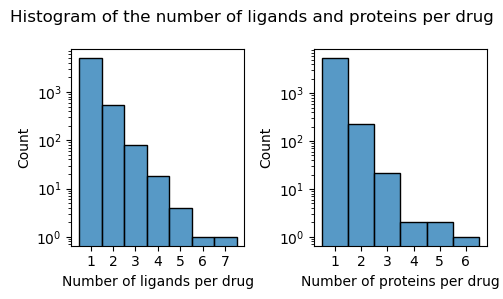

In [86]:
fig,axs = plt.subplots(1,2,figsize=(5,3))

# ligands
sns.histplot(grouped_df["num_lig_per_drug"],ax=axs[0],bins=np.arange(1, grouped_df["num_lig_per_drug"].max() + 2) - 0.5)
axs[0].set_yscale("log")
axs[0].set_xlabel("Number of ligands per drug")
axs[0].set_xticks(np.arange(1, 8, 1))

# proteins
sns.histplot(grouped_df["num_prot_per_drug"], ax=axs[1],bins=np.arange(1, grouped_df["num_prot_per_drug"].max() + 2) - 0.5)
axs[1].set_yscale("log")
axs[1].set_xlabel("Number of proteins per drug")
axs[1].set_xticks(np.arange(1, 7, 1))

plt.suptitle("Histogram of the number of ligands and proteins per drug")
plt.tight_layout()

In [87]:
print("Total number of drugs :                  ",len(grouped_df))
print("Number of drugs with a toxicity report : ",sum(grouped_df["unique_toxicity"].isna() == False)) 
print("Number of unique toxicity reports :      ",len(grouped_df["unique_toxicity"].unique()))

Total number of drugs :                   5716
Number of drugs with a toxicity report :  1410
Number of unique toxicity reports :       1397


# Toxicity score

In [88]:
# Making a large string of all toxicity reports text
unique_toxicity_values = " ".join(grouped_df["unique_toxicity"].unique().astype(str))

In [89]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp(unique_toxicity_values)

In [90]:
# Count the occurances of each word in that sting
words = [token.text for token in doc]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common(5)

print(common_words)

[(',', 9840), ('of', 4577), ('.', 4334), ('and', 4304), ('in', 3832)]


In [91]:


# drop punctuation and stop words
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]

# most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common(1000000)

common_words

[('mg', 1779),
 ('kg', 1511),
 ('\r\n\r\n', 1211),
 ('overdose', 1003),
 ('>', 719),
 ('rats', 693),
 ('dose', 680),
 ('effects', 647),
 ('<', 611),
 ('patients', 560),
 ('oral', 559),
 ('doses', 547),
 ('LD', 538),
 ('include', 507),
 ('sub>50</sub', 460),
 ('studies', 456),
 ('adverse', 447),
 ('day', 415),
 ('human', 412),
 ('times', 400),
 ('mice', 367),
 ('toxicity', 361),
 ('reported', 351),
 ('LD50', 348),
 ('recommended', 339),
 ('FDA', 339),
 ('drug', 319),
 ('nausea', 309),
 ('symptoms', 304),
 ('rat', 298),
 ('supportive', 295),
 ('use', 286),
 ('risk', 282),
 ('vomiting', 273),
 ('Oral', 269),
 ('observed', 263),
 ('Label', 261),
 ('increased', 254),
 ('clinical', 247),
 ('treatment', 242),
 (' ', 236),
 ('hypotension', 232),
 ('administration', 224),
 ('associated', 222),
 ('Symptoms', 219),
 ('mouse', 215),
 ('severe', 213),
 ('including', 211),
 ('\r\n', 207),
 ('renal', 204),
 ('overdosage', 203),
 ('potential', 201),
 ('administered', 196),
 ('reactions', 192),
 ('preg

Hand picked words 

In [92]:
toxicity_related_frequent_words = ["overdose","adverse",'toxicity','LD50','nausea','vomiting','renal','hypotension','severe',
                                    'pain','fetal','pregnancy','reactions','fertility','blood','cardiac',"overdosage",'respiratory'
                                    ,'symptomatic','diarrhea','acute','headache','gastrointestinal','depression',"dizziness","coma",
                                    'liver','failure','mutagenic','acid','heart','abdominal','bradycardia','impairment','convulsions',
                                    'hypertension','anemia','anaphylactic','anaphylaxis','arrhythmias','arrhythmia','asthma','bronchospasm',
                                    'bronchial','cancer','carcinogenic','carcinogenicity','cardiotoxicity','cardiovascular','gastric',
                                    'seizures','confusion','hepatic',"carcinogenicity",'death','rash','mutation','arrhythmias',
                                    "overdose","patients", "effects","adverse","toxicity","symptoms","nausea","vomiting","treatment",
                                    "renal","hypotension","pregnancy","severe","pain","fetal","reactions","fertility","cardiac","diarrhea",
                                    "headache","gastrointestinal","depression","dizziness","coma","respiratory","symptomatic","acne",
                                    "liver","failure","drowsiness","seizures","muscle","maternal","gastric","hypertension","death",
                                    "rash","bladder","edema","children","weakness","insomnia","syndrome","anemia","tumors","acidosis",
                                    "impaired","infant","pediatric","hallucinations","nervous","irritation","fever","constipation",
                                    "adenomas","birth","gestation","developmental","prolonged","mutagenicity","lethal","fatigue",
                                    "sedation","thrombocytopenia","bradycardia","tachycardia","convulsions","arrhythmias","CNS","somnolence",
                                    "hemodialysis","breast","acne","hepatotoxicity","pulmonary","malformations","thrombocytopenia",
                                    "lactation","ventricular","sweating","atropine","kidney","hepatotoxicity","restlessness",
                                    "seizure","emesis","adrenal","carcinomas","neutropenia","allergy","toxicity","arrhythmias",
                                    "death","hypertension"]

high_severity = ["cancer","coma","severe","overdose","death","lethal","serious","life-threatening","life threatening","strokes","fatal","mortality"]

In [93]:

toxicity_related_frequent_words = np.unique(toxicity_related_frequent_words)

low_severity = [word for word in toxicity_related_frequent_words if word not in high_severity]


In [94]:
import re
from bs4 import BeautifulSoup  # Use BeautifulSoup for HTML tag removal

# Function to parse text and find lowest LD50 value if there is any
def parse_lowest_ld50(report):
    clean_report = BeautifulSoup(report, "html.parser").get_text()
    matches = re.findall(r"LD50[^\d]*(\d+)\s*mg/kg", clean_report, re.IGNORECASE)
    if matches:
        # Convert matches to int and find the minimum
        ld50_values = list(map(int, matches))
        return int(min(ld50_values))
    return 0  # No LD50 value found


# Assign a severity score to each drug based on LD50 value (score pseudo-arbitrary)
def assign_severity_score(ld50):
    if ld50 is None:
        return 0  # No value, no score
    if ld50 < 5000 and ld50 > 0:
        return max(5 - ld50/5000,0)
    else :
        return 0

## Toxicity scoring 
The toxicity score is made from adding the score from a possible LD50 value, and weighted number of severity/toxicity/... related words. This score is then normalized by the word length of the toxicity report.

In [95]:
# all
grouped_df["toxicity_score"] =  grouped_df["unique_toxicity"].apply(lambda x: (sum(3 for word in high_severity if word in str(x)) + sum(1 for word in low_severity if word in str(x)) + int(assign_severity_score(parse_lowest_ld50(str(x))))) )
grouped_df["toxicity_score"] =  grouped_df["toxicity_score"]/grouped_df["unique_toxicity"].apply(lambda x: len(str(x).split()) if len(str(x).split()) != 0 else 0)

# cancer most studied
grouped_df_studied["toxicity_score"] =  grouped_df_studied["unique_toxicity"].apply(lambda x: (sum(3 for word in high_severity if word in str(x)) + sum(1 for word in low_severity if word in str(x)) + (assign_severity_score(parse_lowest_ld50(str(x))))) )
grouped_df_studied["toxicity_score"] =  grouped_df_studied["toxicity_score"]/grouped_df_studied["unique_toxicity"].apply(lambda x: len(str(x).split()) if len(str(x).split()) != 0 else 0)


/var/folders/_h/sv2httr97w1d8pv18rsdrqhc0000gn/T/ipykernel_45889/971890102.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_report = BeautifulSoup(report, "html.parser").get_text()
/var/folders/_h/sv2httr97w1d8pv18rsdrqhc0000gn/T/ipykernel_45889/971890102.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_report = BeautifulSoup(report, "html.parser").get_text()


### Data frame with only non-empty toxicity report

In [96]:
grouped_df_tox = grouped_df.loc[grouped_df["unique_toxicity"].isna() == False]
grouped_df_studied_tox = grouped_df_studied.loc[grouped_df_studied["unique_toxicity"].isna() == False]

Text(0.5, 1.0, 'Histogram of the toxicity score')

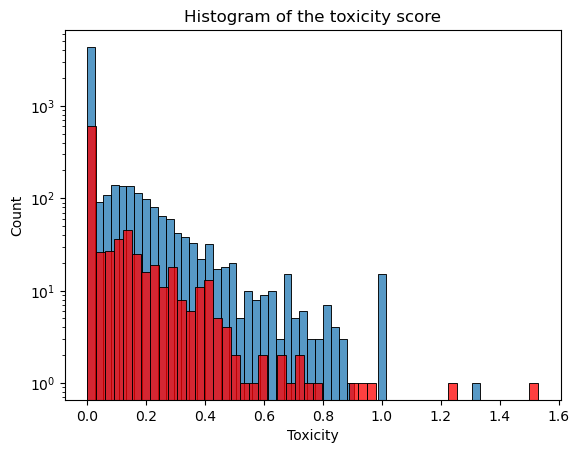

In [97]:
sns.histplot(grouped_df["toxicity_score"], bins=50)
sns.histplot(grouped_df_studied["toxicity_score"], bins=50,color="red")

plt.yscale("log")
plt.xlabel("Toxicity")
plt.title("Histogram of the toxicity score")

#### Without empty tox report

Text(0.5, 1.0, 'Histogram of toxicity score')

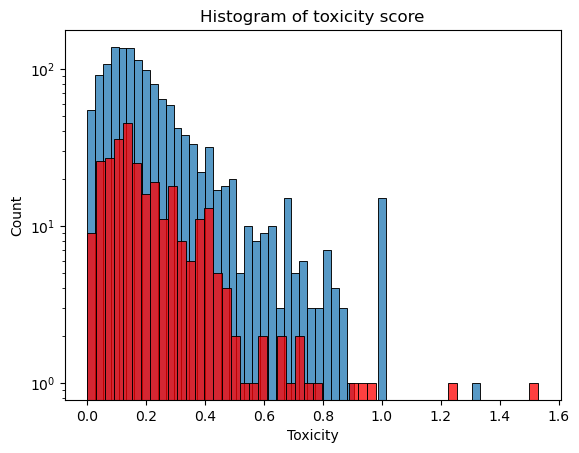

In [98]:
sns.histplot(grouped_df_tox["toxicity_score"], bins=50)
sns.histplot(grouped_df_studied_tox["toxicity_score"], bins=50,color="red")

plt.yscale("log")
plt.xlabel("Toxicity")
plt.title("Histogram of toxicity score")

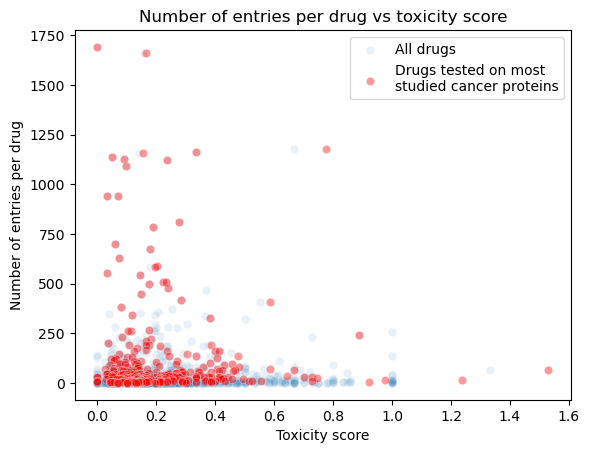

In [99]:
sns.scatterplot(grouped_df_tox,x="toxicity_score",y = "count",alpha = 0.1)
sns.scatterplot(grouped_df_studied_tox,x="toxicity_score",y = "count",alpha = 0.4,color="red")

plt.xlabel("Toxicity score")
plt.ylabel("Number of entries per drug")
plt.title("Number of entries per drug vs toxicity score")
plt.legend(["All drugs","Drugs tested on most\nstudied cancer proteins"])

In [100]:
grouped_df.loc[grouped_df.toxicity_score > 1.2,"unique_toxicity"]

drugbank_drug_name
Astemizole    LD<sub>50</sub>=2052mg/kg in mice
Name: unique_toxicity, dtype: object